In [2]:
import pandas as pd
from dataclasses import dataclass, asdict
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
from sklearn.utils.multiclass import type_of_target

import helpers
import consts
from dto import TaskRawData

helpers.period_days = 7

In [3]:
collumn_names = TaskRawData.collumn()

In [4]:
df = pd.DataFrame.from_records([asdict(task) for task in helpers.generate_dataset()])
df

,process_name,task_name,owner,assigner,start_time,end_time,due_time,priority,var_count
0,Поддержка,Фикс чего-то там,Василёк,Ден,2021-08-30 18:25:38,2021-08-31 02:03:44.102093,2021-08-30 21:25:38,8,2
1,Поддержка,Фикс чего-то там,Василёк,Абстрактный джун JS'a,2021-09-01 16:56:58,2021-09-01 19:54:49.657979,2021-09-01 19:56:58,8,2
2,Поддержка,Фикс чего-то там,Василёк,Ванёк,2021-09-03 07:38:53,2021-09-03 10:34:50.675225,2021-09-03 10:38:53,8,2
3,Поддержка,Фикс чего-то там,Василёк,Абстрактный джун питона,2021-09-04 09:02:56,2021-09-04 12:09:04.818675,2021-09-04 12:02:56,8,2
4,Поддержка,Фикс чего-то там,Василёк,Ванёк,2021-09-03 12:25:35,2021-09-03 14:32:28.227449,2021-09-03 15:25:35,8,2
...,...,...,...,...,...,...,...,...,...
4995,Разработка,Сделай гугл,Василёк,Абстрактный джун devopa,2021-09-03 18:53:48,2021-09-05 09:21:08.132475,2021-09-03 22:53:48,6,228
4996,Разработка,Сделай гугл,Василёк,Абстрактный джун JS'a,2021-08-29 16:39:09,2021-08-31 02:57:24.755219,2021-08-29 20:39:09,6,228
4997,Разработка,Сделай гугл,Василёк,Абстрактный джун JS'a,2021-08-31 11:12:43,2021-09-01 01:00:45.543023,2021-08-31 15:12:43,6,228
4998,Разработка,Сделай гугл,Василёк,Петя,2021-08-29 19:17:15,2021-08-30 00:03:01.938427,2021-08-29 23:17:15,6,228


In [5]:
df = helpers.date_preprocessing(df)

In [6]:
df['other_task_on_start'] = helpers.other_task_on_start(df)
df['elapsed'] = helpers.calculate_target_with_noise(df)



In [7]:
# кодируем категориальные признаки

for sign in consts.categorial_sign:
    tmp = pd.get_dummies(df[sign], prefix=sign)
    df = pd.concat([df,tmp], axis=1)


вроде более менее преобразованные данные получились,
необходимо убрать лишнее, это незакодированные категориальные признаки и возможно стоит убрать необработанное время
целевой признак затраченное время(elapsed)

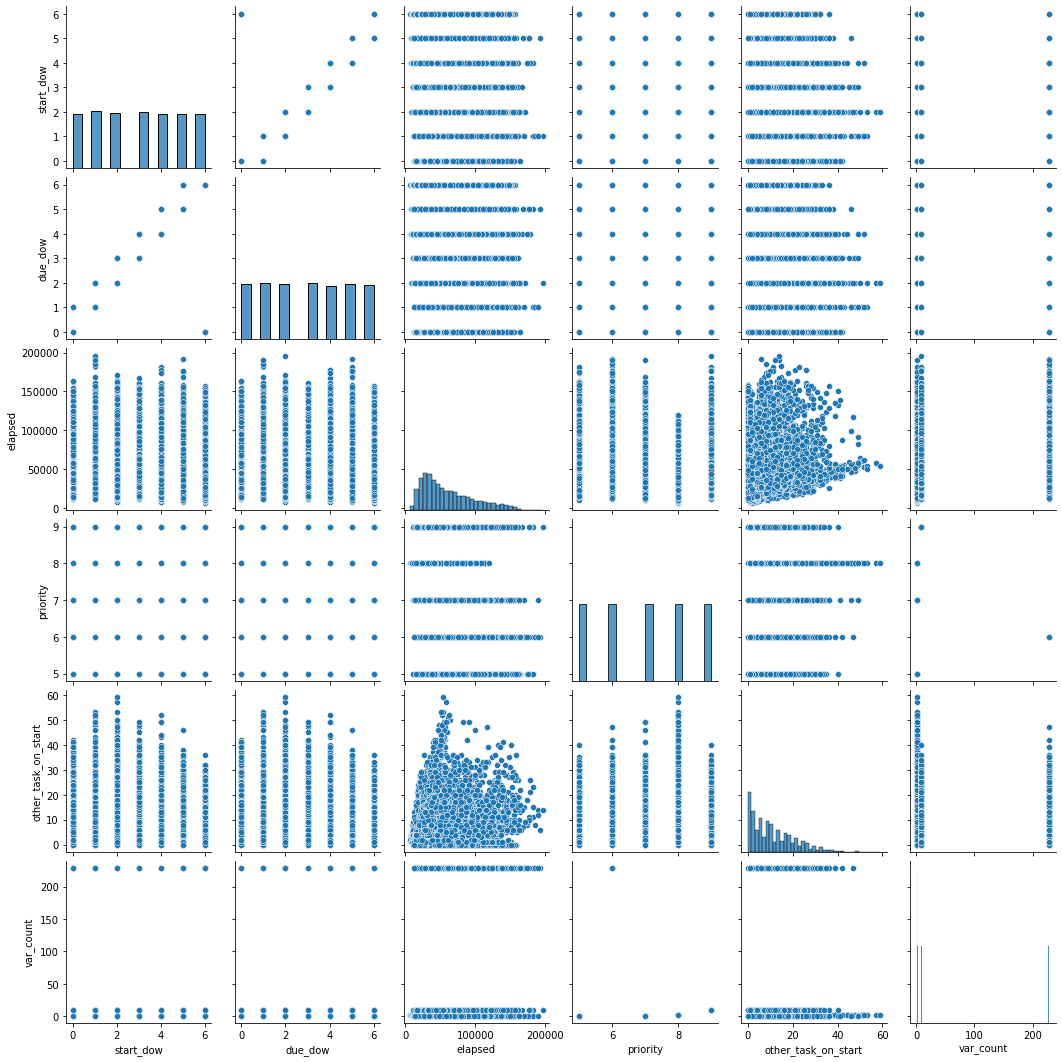

In [8]:

sns_plot = sns.pairplot(df[consts.pairplot_cols])

можно увидеть какие признаки точно влияют на целевой, а какие не очень

In [9]:
# "task_name_number", "assigner_number"
df = df.drop(columns=consts.need_drop)

In [10]:
corr_matrix = df.corr().abs()
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))
# sol[:30]

т.к. корреляция признаков сильная, попробуем использовать Ridge  и Lasso регрессии

In [11]:

Y = df.elapsed.values
X = df.drop(columns=['elapsed'])
type_of_target(Y)


'multiclass'

In [12]:
# X.head()
# X

In [13]:

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, ShuffleSplit

from models import scaler, ridge, lasso, skf, cv

print(ridge, lasso)


scaler.fit(X) 
# save scaler

X_scaled = scaler.transform(X)



RidgeCV(alphas=array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])) LassoCV(max_iter=10000, random_state=42)


In [14]:
# check r2 score for comparison models
ridge_cvs = cross_val_score(ridge, X_scaled, Y, cv=cv)
lasso_cvs = cross_val_score(lasso, X_scaled, Y, cv=cv)
print(ridge_cvs)
print(lasso_cvs)
print(ridge_cvs.mean(), lasso_cvs.mean())

[0.56929273 0.57483202 0.58515349]
[0.56892123 0.57618215 0.58622945]
0.5764260780608459 0.5771109401780197


 Для приемлемых моделей предполагается, что коэффициент детерминации должен быть хотя бы не меньше 50 % (в этом случае коэффициент множественной корреляции превышает по модулю 70 %). Модели с коэффициентом детерминации выше 80 % можно признать достаточно хорошими (коэффициент корреляции превышает 90 %). Значение коэффициента детерминации 1 означает функциональную зависимость между переменными.
 
У нас на синтетических данных явно прослеживается зависимость от количвества других задач на время начала задачи и приоритета задачи, поэтому коэфициент детерминации высокий

In [15]:

split_indexes = skf.split(X_scaled, Y)
ridge = helpers.fit_model(ridge, X_scaled, Y, split_indexes)

split_indexes = skf.split(X_scaled, Y)
lasso = helpers.fit_model(lasso, X_scaled, Y, split_indexes)



######


ValueError: n_splits=3 cannot be greater than the number of members in each class.

In [ ]:
ridge.feature_names = list(X.columns.values)
lasso.feature_names = list(X.columns.values)

## SAVE models

In [ ]:
from joblib import dump
dump(ridge, 'ridge.joblib') 
dump(lasso, 'lasso.joblib')

dump(scaler, 'scaler.joblib')
# model = joblib.load("lasso.joblib")


In [ ]:
# from joblib import load
# import numpy as np
# model = load("lasso.joblib")
# model.predict(np.array([ 0.        , -1.16247639,  1.54901047,  1.54901047, -0.53935003,
#         1.73205081, -0.57735027, -0.57735027, -0.57735027, -0.57735027,
#        -0.57735027, -0.57735027,  1.73205081,  0.        , -0.69916647,
#        -0.68468113,  1.35531525, -0.41733475, -0.44989422, -0.37652323,
#        -0.42692623, -0.35305601,  2.29128785, -0.39364538, -0.41733475,
#        -0.44989422, -0.37652323, -0.42692623, -0.35305601,  2.29128785,
#        -0.39364538]).reshape(1,-1))

## predict example
берем задачу и преобразуем под вид, который принимает модель

In [18]:

task_example = TaskRawData(
    process_name="Разработка",
    task_name="Сделай гугл",
    owner="Василек",
    assigner="Игорь",
    start_time=datetime(2021, 8, 31, 17, 51, 58),
    end_time=None,
    due_time=datetime(2021, 8, 31, 18, 51, 58),
    priority=9,
    var_count=1  
)
# TaskRawData(process_name='Заказ товара', task_name='проверка склада', owner='BOSS', assigner='Глеб', start_time=datetime.datetime(2021, 8, 31, 17, 51, 58), end_time=datetime.datetime(2021, 8, 31, 18, 51, 18, 302065), due_time=datetime.datetime(2021, 8, 31, 18, 51, 58), priority=50, var_count=1)

In [ ]:
from joblib import load

model = load("ridge.joblib")
scaler = load("scaler.joblib")

assigner = "Глеб"
task_example.assigner = assigner

active_task_count = 4
processing_val = helpers.processing_val([task_example], active_task_count, model, scaler)
predict = model.predict(processing_val)
print(predict)